In [ ]:
!pip install shap

In [ ]:
!pip install optuna

In [3]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import neighbors
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn import metrics
import optuna
import shap
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [47]:
D = pd.read_csv('cancer_patient_data_sets.csv')
D = D.drop('Patient Id', axis=1)
D = D.drop('index', axis=1)

In [48]:
# low -> 0, Medium -> 1, High -> 2
D = D.replace({
   'Level': {'Low': int(0), 'Medium': int(1), 'High':int(2)},})
D.head()

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,0
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,1
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,2
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,2
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,2


In [49]:
# Creacion lotes de entrenamiento y test
from sklearn.model_selection import train_test_split
X = D.drop(columns=['Level'])
y = D['Level']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=0) # 0.25 * 0.8 = 0.2

2    225
1    202
0    173
Name: Level, dtype: int64


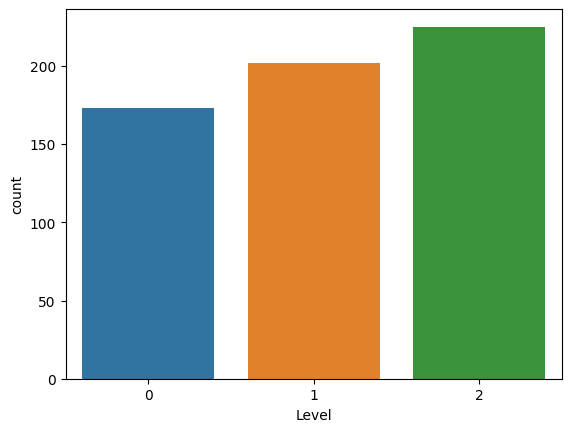

In [50]:
# Visualizar la cantidad de etiquetas de cada clase en el lote de entreamiento
import seaborn as sns
import matplotlib.pyplot as plt
print(y_train.value_counts())
sns.countplot(x = y_train)
plt.xticks(rotation = 0);

In [51]:
def objectiveRF(trial):
    crit=trial.suggest_categorical('Criterion',['gini', 'entropy', 'log_loss'])
    depth=trial.suggest_int('Max_depth',1,15)
    n=trial.suggest_int('estimators',1,150)

    #entrenamiento
    RF=ensemble.RandomForestClassifier(n_estimators=n,criterion=crit,max_depth=depth)
    RF.fit(X_train,y_train)

    #prediccion
    y_pred = RF.predict(X_test)

    #metrica
    recall=metrics.recall_score(y_test,y_pred,average='micro')
    return recall

studyRF = optuna.create_study(direction='maximize')
studyRF.optimize(objectiveRF, n_trials=100)

In [52]:
print(studyRF.best_params)
optuna.visualization.plot_optimization_history(studyRF)

{'Criterion': 'entropy', 'Max_depth': 11, 'estimators': 73}


In [53]:
optuna.visualization.plot_param_importances(studyRF)

              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        63
      Medium       1.00      1.00      1.00        72
        High       1.00      1.00      1.00        65

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



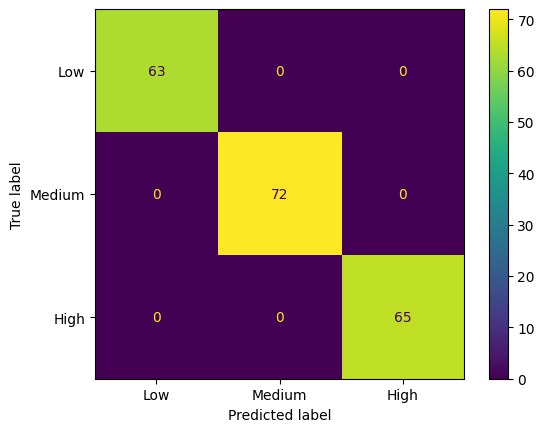

In [54]:
crit=studyRF.best_params['Criterion']
depth=studyRF.best_params['Max_depth']
n=studyRF.best_params['estimators']


RF=ensemble.RandomForestClassifier(n_estimators=n,criterion=crit,max_depth=depth)
RF.fit(X_train,y_train)

#prediccion
y_pred = RF.predict(X_val)

#metricas
print(metrics.classification_report(y_val,y_pred,target_names=['Low','Medium','High']))

cm=metrics.confusion_matrix(y_val,y_pred)
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Low','Medium','High'])
disp.plot()

In [55]:
explainer_rfc = shap.Explainer(RF)
shap_values_rfc = explainer_rfc(X_test)

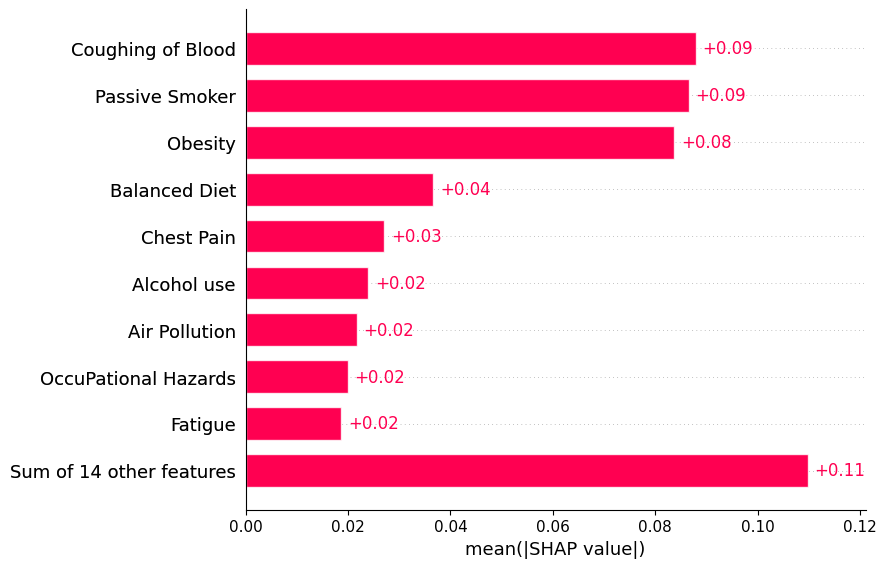

In [73]:
shap.initjs()
shap.plots.bar(shap_values_rfc[:, :, 2])

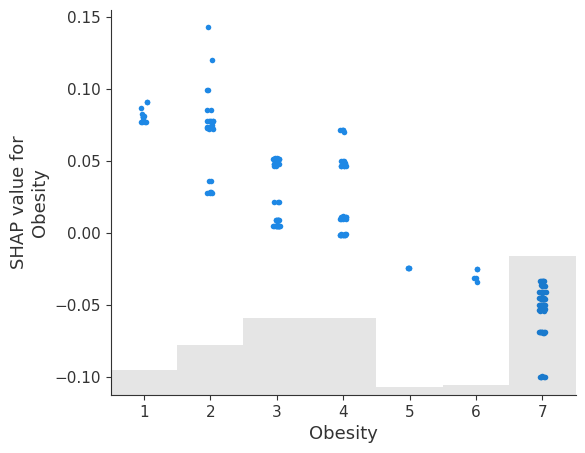

In [71]:
shap.plots.scatter(shap_values_rfc[:, "Obesity", 0])

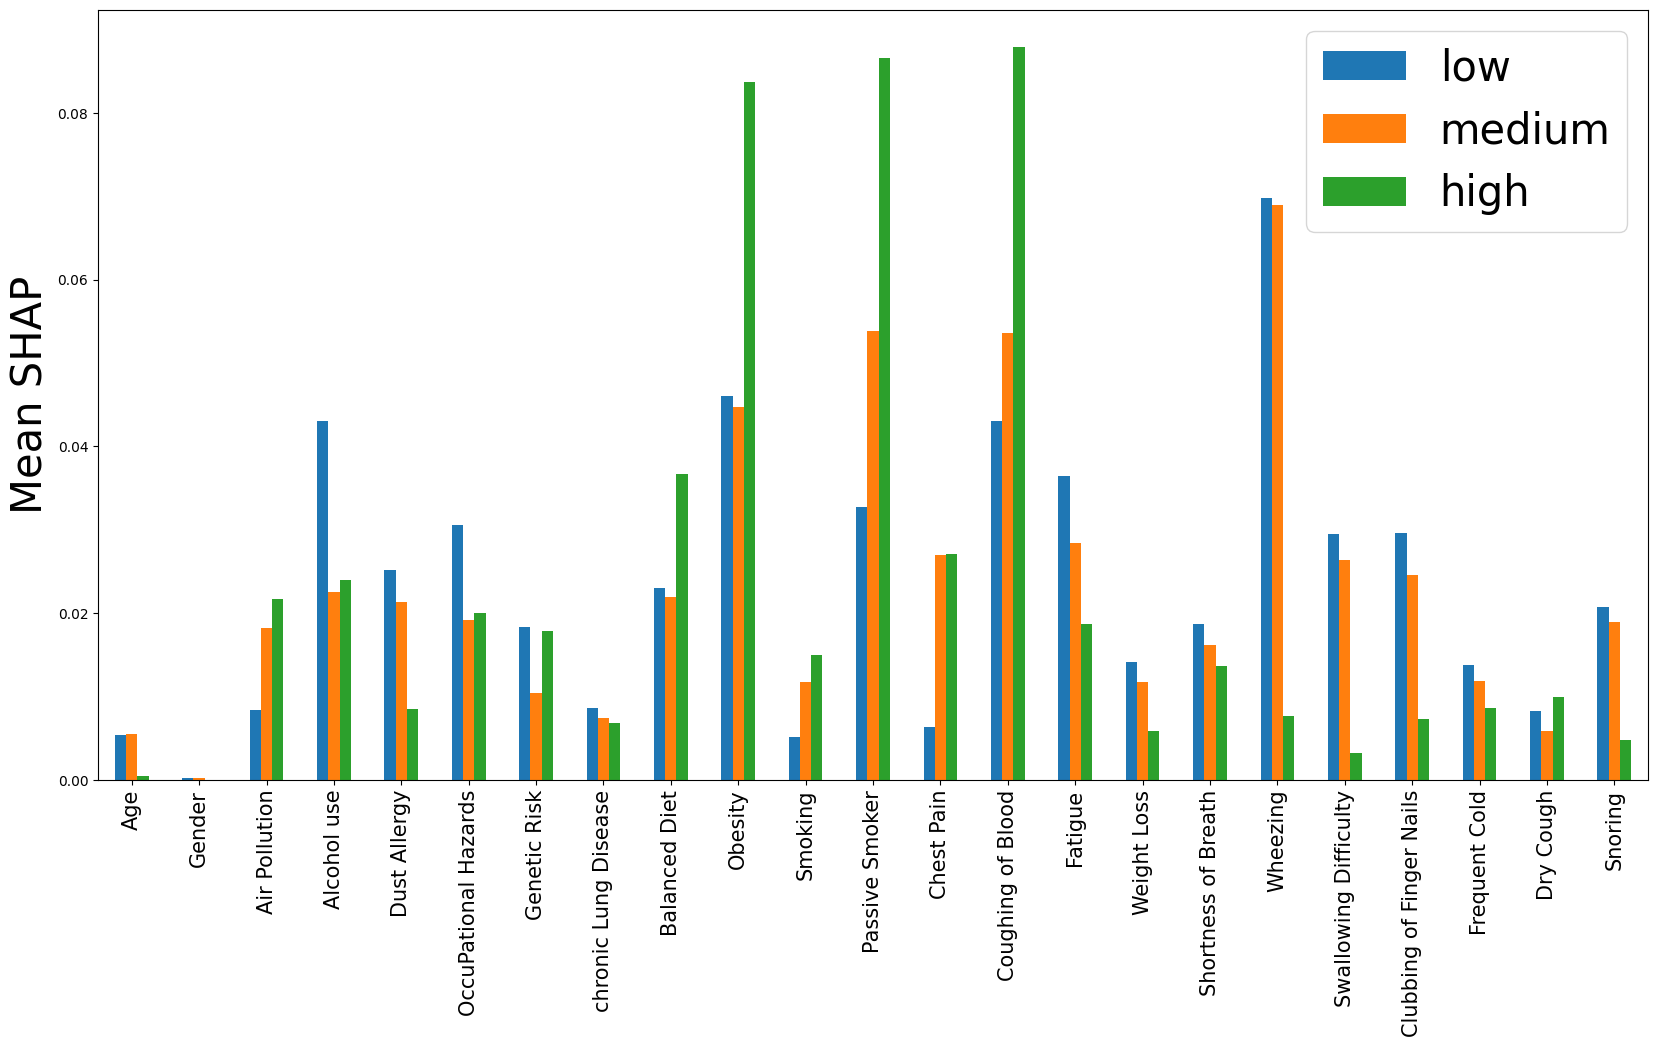

In [57]:
# calculate mean SHAP values for each class
mean_0 = np.mean(np.abs(shap_values_rfc.values[:,:,0]),axis=0)
mean_1 = np.mean(np.abs(shap_values_rfc.values[:,:,1]),axis=0)
mean_2 = np.mean(np.abs(shap_values_rfc.values[:,:,2]),axis=0)

df = pd.DataFrame({'low':mean_0,'medium':mean_1,'high':mean_2})

# plot mean SHAP values
fig,ax = plt.subplots(1,1,figsize=(20,10))
df.plot.bar(ax=ax)

ax.set_ylabel('Mean SHAP',size = 30)
ax.set_xticklabels(X.columns,rotation=90,size=15)
ax.legend(fontsize=30)

In [23]:
new_shap_values = []
for i, pred in enumerate(y_pred):
    # get shap values for predicted class
    new_shap_values.append(shap_values_rfc.values[i][:,pred])

In [24]:
shap_values_rfc.values = np.array(new_shap_values)
print(shap_values_rfc.shape)

(200, 23)


In [76]:
shap.plots.bar(shap_values_rfc)

IndexError: ignored

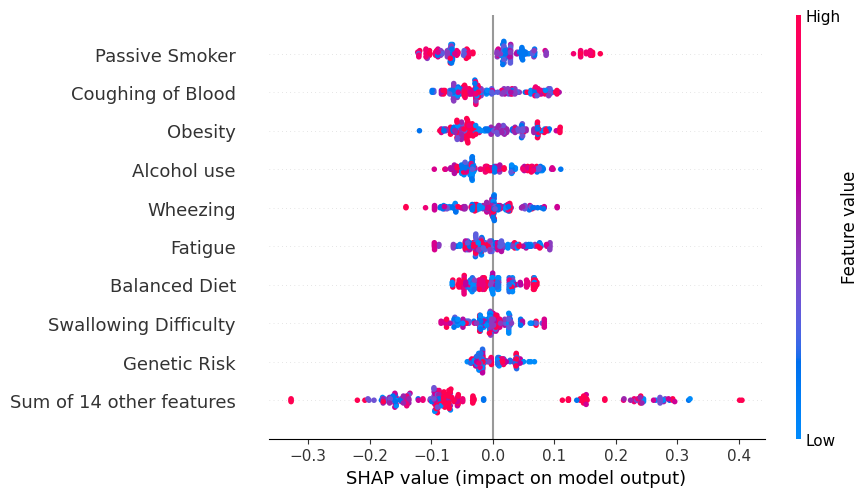

In [26]:
shap.plots.beeswarm(shap_values_rfc)

## SVM
Ahora veremos el caso de svm

In [58]:
def objectiveSVM(trial):
    svm_C=trial.suggest_float('svm_C',1e-10,1e5,log=True)
    krn=trial.suggest_categorical('Kernel',['linear','poly','rbf','sigmoid'])

    #entrenamiento
    mvs=svm.SVC(C=svm_C,kernel=krn)
    mvs.fit(X_train,y_train)

    #prediccion
    y_pred = mvs.predict(X_test)

    #metrica
    recall=metrics.recall_score(y_test,y_pred,average='micro')
    return recall

studySVM = optuna.create_study(direction='maximize')
studySVM.optimize(objectiveSVM, n_trials=100)

In [59]:
print(studySVM.best_params)
optuna.visualization.plot_optimization_history(studySVM)

{'svm_C': 19481.90685031533, 'Kernel': 'linear'}


In [60]:
optuna.visualization.plot_param_importances(studySVM)

              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        63
      Medium       1.00      1.00      1.00        72
        High       1.00      1.00      1.00        65

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



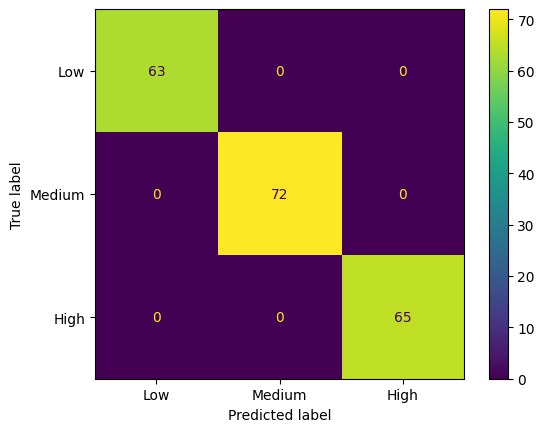

In [61]:
CBest=studySVM.best_params['svm_C']
krn=studySVM.best_params['Kernel']

mvs=svm.SVC(C=CBest,kernel=krn)
mvs.fit(X_train,y_train)

#prediccion
y_pred = mvs.predict(X_val)

#metricas
print(metrics.classification_report(y_val,y_pred,target_names=['Low','Medium','High']))

cm=metrics.confusion_matrix(y_val,y_pred)
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Low','Medium','High'])
disp.plot()

In [62]:
explainer_svm = shap.KernelExplainer(mvs.predict, X_train.sample(20, random_state=1234))
shap_values_svm = explainer_svm(X_test)

  0%|          | 0/200 [00:00<?, ?it/s]

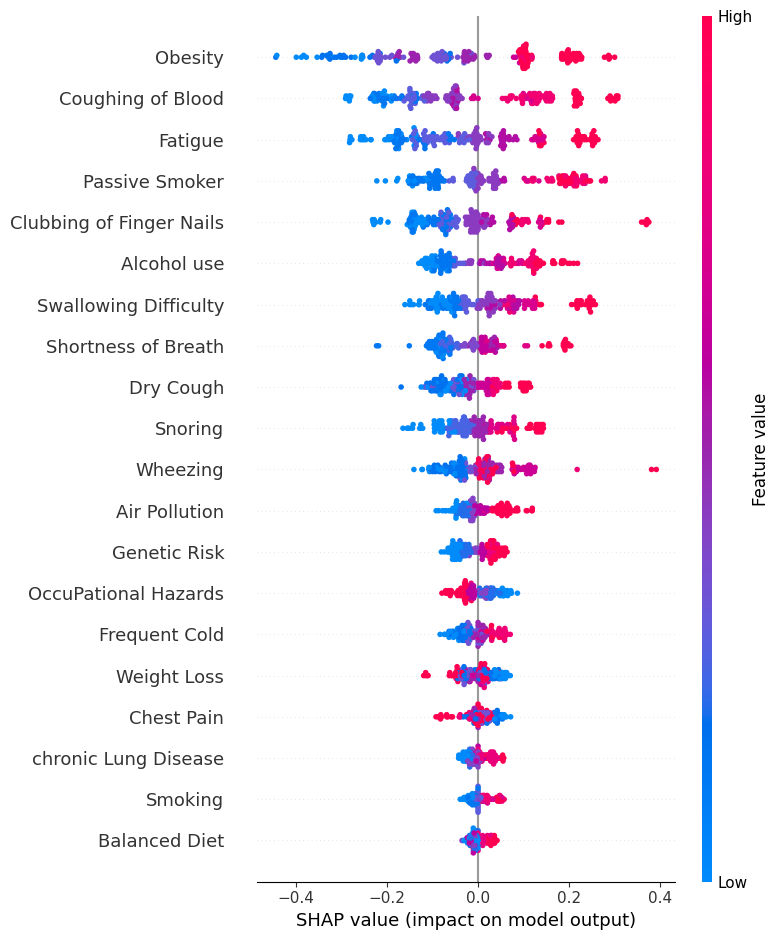

In [77]:
shap.summary_plot(shap_values_svm, X_test)

In [78]:
def objectiveKNN(trial):
    k=trial.suggest_int('K',1,20)

    #entrenamiento
    KNN=neighbors.KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train,y_train)

    #prediccion
    y_pred = KNN.predict(X_test)

    #metrica
    recall=metrics.recall_score(y_test,y_pred,average='micro')
    return recall

studyKNN = optuna.create_study(direction='maximize')
studyKNN.optimize(objectiveKNN, n_trials=100)

In [79]:
print(studyKNN.best_params)
optuna.visualization.plot_optimization_history(studyKNN)

{'K': 2}


              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        63
      Medium       1.00      1.00      1.00        72
        High       1.00      1.00      1.00        65

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



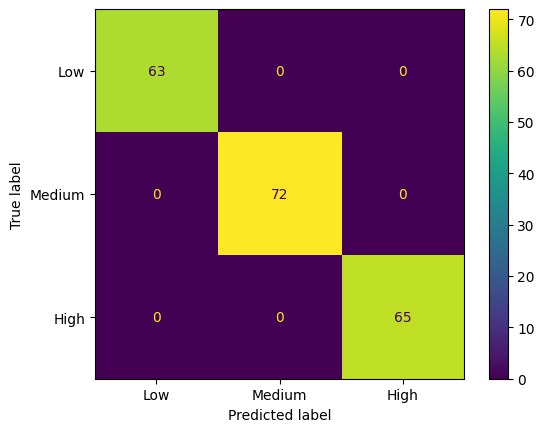

In [80]:
k=studyKNN.best_params['K']


#entrenamiento
KNN=neighbors.KNeighborsClassifier(n_neighbors=k)
KNN.fit(X_train,y_train)

#prediccion
y_pred = KNN.predict(X_val)

#metricas
print(metrics.classification_report(y_val,y_pred,target_names=['Low','Medium','High']))

cm=metrics.confusion_matrix(y_val,y_pred)
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Low','Medium','High'])
disp.plot()

In [83]:
explainer_knn = shap.KernelExplainer(KNN.predict_proba, X_train.sample(15))
shap_values_knn = explainer_knn.shap_values(X_test)

  0%|          | 0/200 [00:00<?, ?it/s]

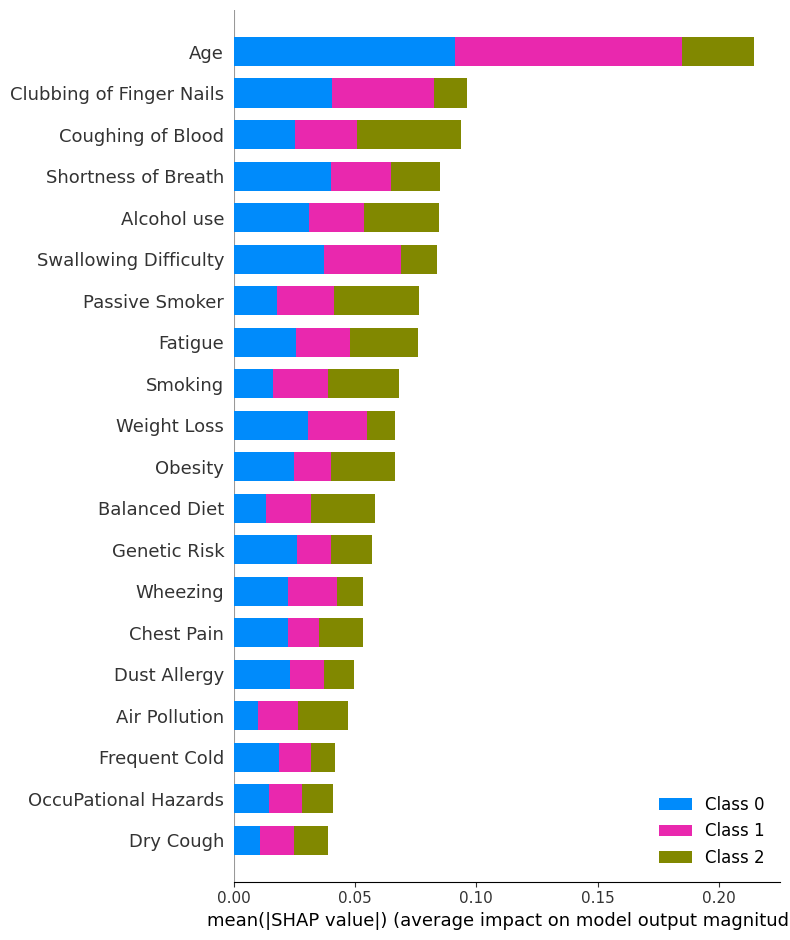

In [84]:
shap.summary_plot(shap_values_knn, X_test)